In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, predict_r0_multipliers, save_r0_mul
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_r0_multipliers

import yaml

In [11]:
predictions_dict = {}

In [35]:
config_filename = 'weights.yaml'
config = read_config(config_filename)

In [39]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_08102020_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 153                 | 154                 | 155                 | 156                 | 157                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-09-27 00:00:00 | 2020-09-28 00:00:00 | 2020-09-29 00:00:00 | 2020-09-30 00:00:00 | 2020-10-01 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 198706.29           | 200876.71           | 201972.33           | 203049.8            | 204100.75  

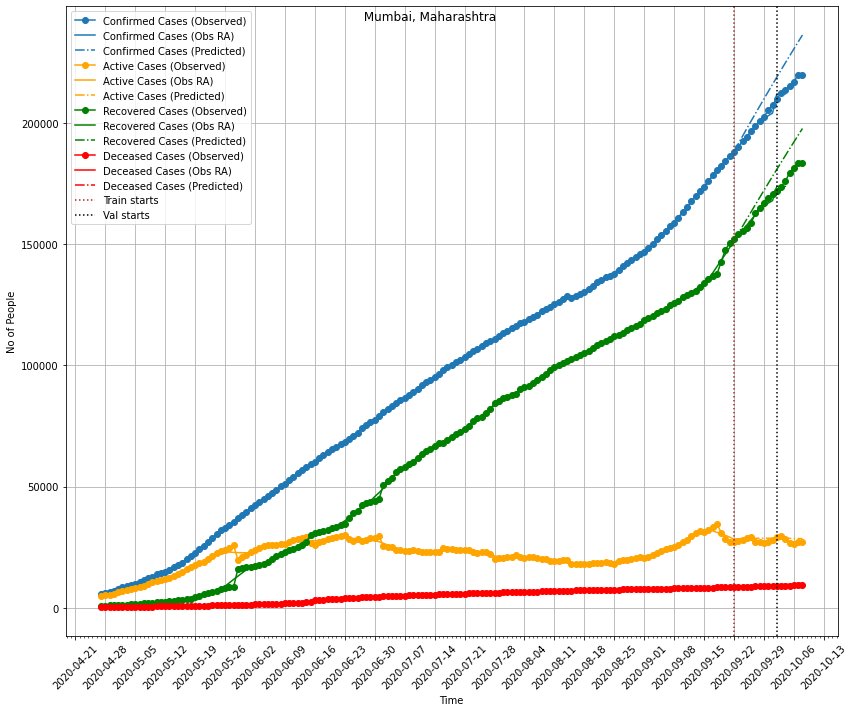

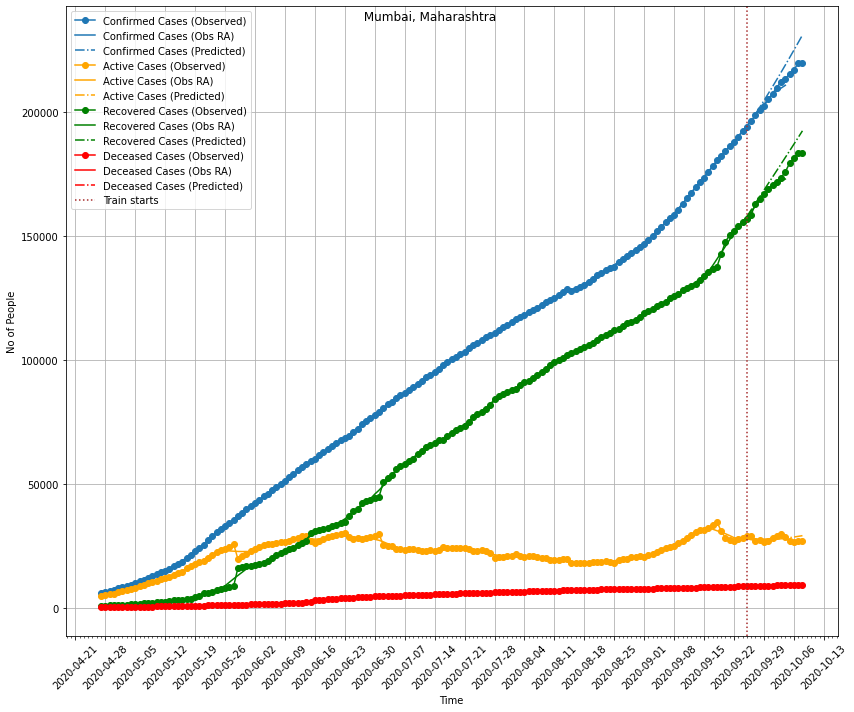

In [40]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [41]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 0.47571341715991744,
 'I_hosp_ratio': 0.43467133800829943,
 'P_fatal': 0.08239586577892491,
 'T_inc': 4.587973271008796,
 'T_inf': 3.765278630598774,
 'T_recov': 8.604094902630875,
 'T_recov_fatal': 38.86703835478135,
 'lockdown_R0': 1.142040324653369}

In [42]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 0.47226576532081166,
 'I_hosp_ratio': 0.2502690911044366,
 'P_fatal': 0.06823276847215935,
 'T_inc': 4.300150101183569,
 'T_inf': 3.067463394791226,
 'T_recov': 9.412869330129991,
 'T_recov_fatal': 39.94301530690423,
 'lockdown_R0': 1.2991136896323627}

## Loss Dataframes

### M1 Loss DataFrame

In [43]:
predictions_dict['m1']['df_loss']

train      val
total      42.8819  84.4952
active     89.7141  100.134
recovered  68.4145  47.5107
deceased   77.4258  127.717

### M2 Loss DataFrame

In [44]:
predictions_dict['m2']['df_loss']

train
total      35.3828
active     117.197
recovered  45.7262
deceased   37.7337

## Sensitivity Plot

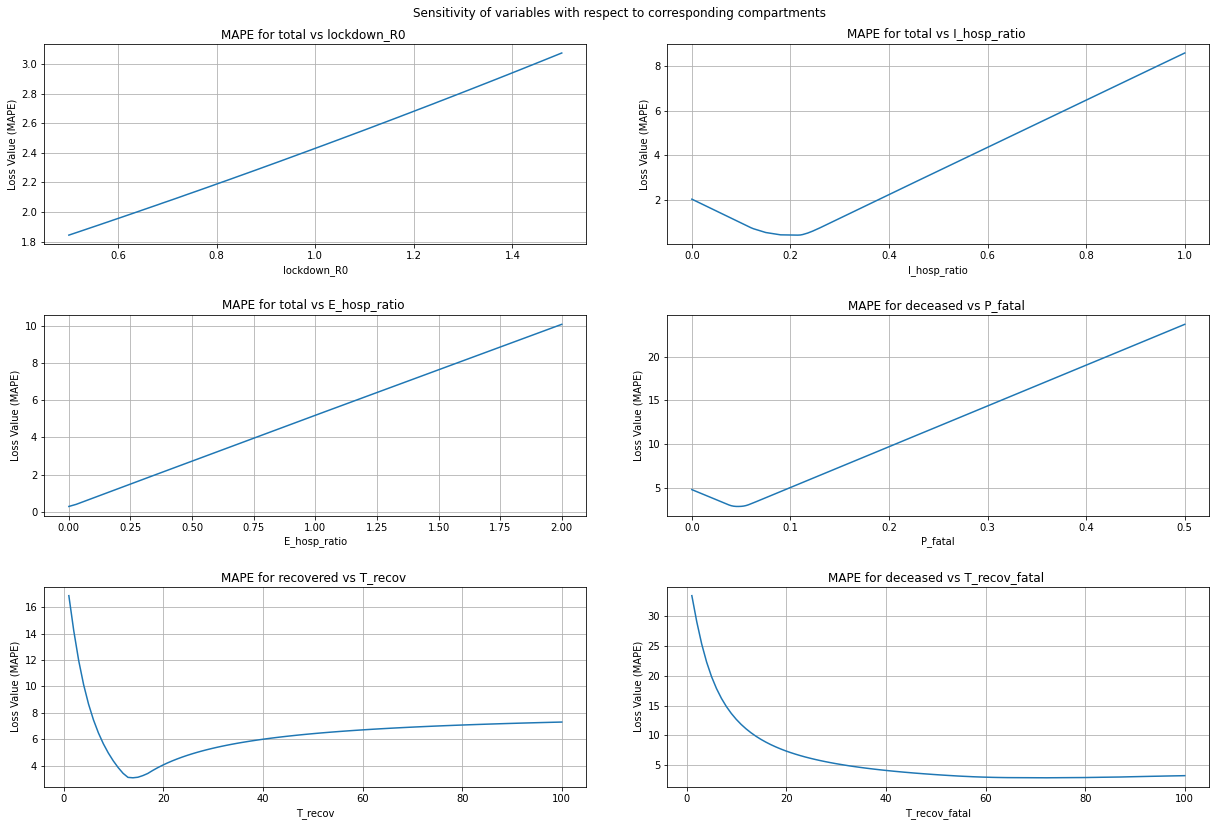

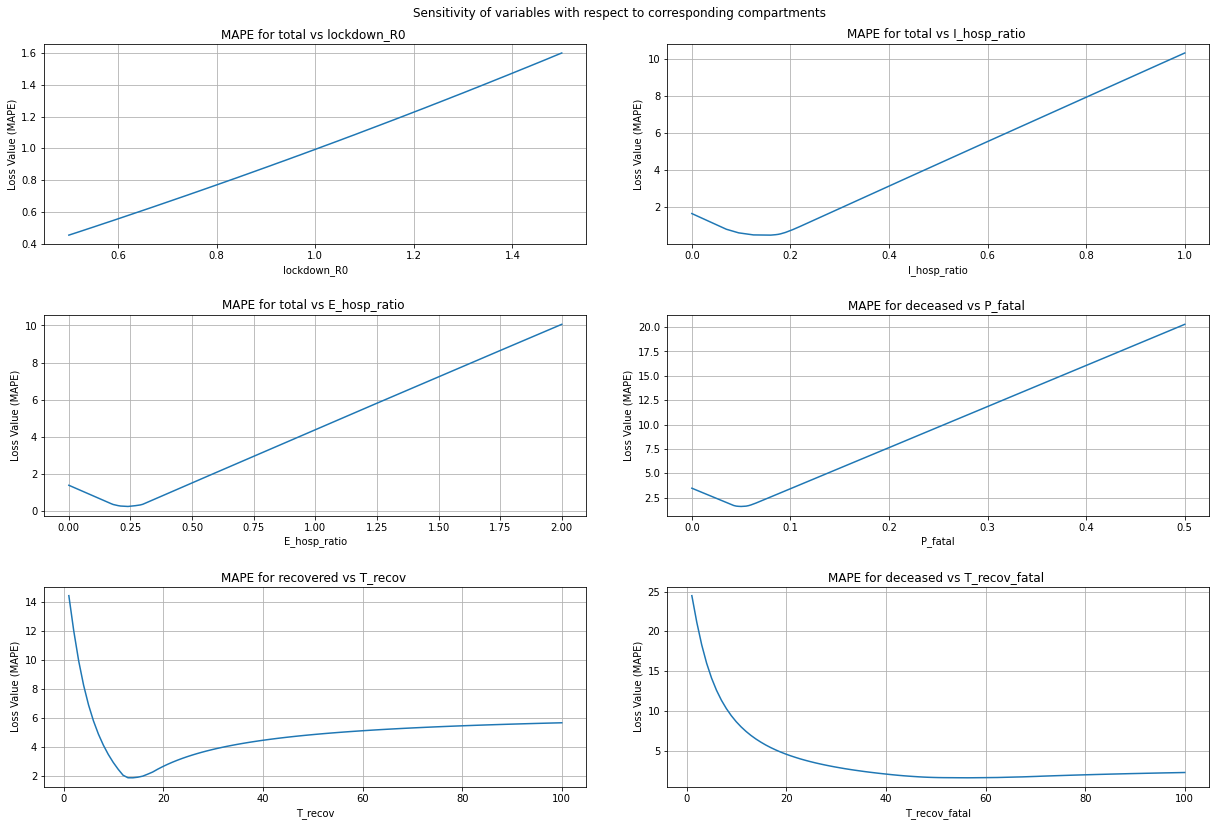

In [45]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

## Plot Forecasts

In [46]:
# M2 based forecasting for the next train_period + test_period + forecast_period (no validation period)
predictions_dict['m2']['forecasts'] = {}
predictions_dict['m2']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m2', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'])

getting forecasts ..


[         date        S      E      I  R_recov  R_fatal       C      D  active  \
0  2020-09-25  1185408  13157   6972    25959     1900  157901   8700   27859   
1  2020-09-26  1182790  12767   7598    25450     2014  160629   8749   27464   
2  2020-09-27  1179998  12612   7998    25138     2136  163315   8801   27274   
3  2020-09-28  1177095  12586   8272    24951     2262  165975   8856   27213   
4  2020-09-29  1174115  12634   8472    24851     2390  168620   8914   27241   
5  2020-09-30  1171081  12721   8631    24812     2519  171257   8975   27331   
6  2020-10-01  1168003  12828   8766    24818     2648  173894   9040   27466   
7  2020-10-02  1164888  12946   8885    24861     2776  176532   9108   27637   
8  2020-10-03  1161742  13068   8995    24933     2904  179177   9179   27837   
9  2020-10-04  1158566  13190   9099    25027     3031  181831   9253   28058   
10 2020-10-05  1155364  13310   9198    25141     3157  184496   9331   28298   
11 2020-10-06  1152137  134

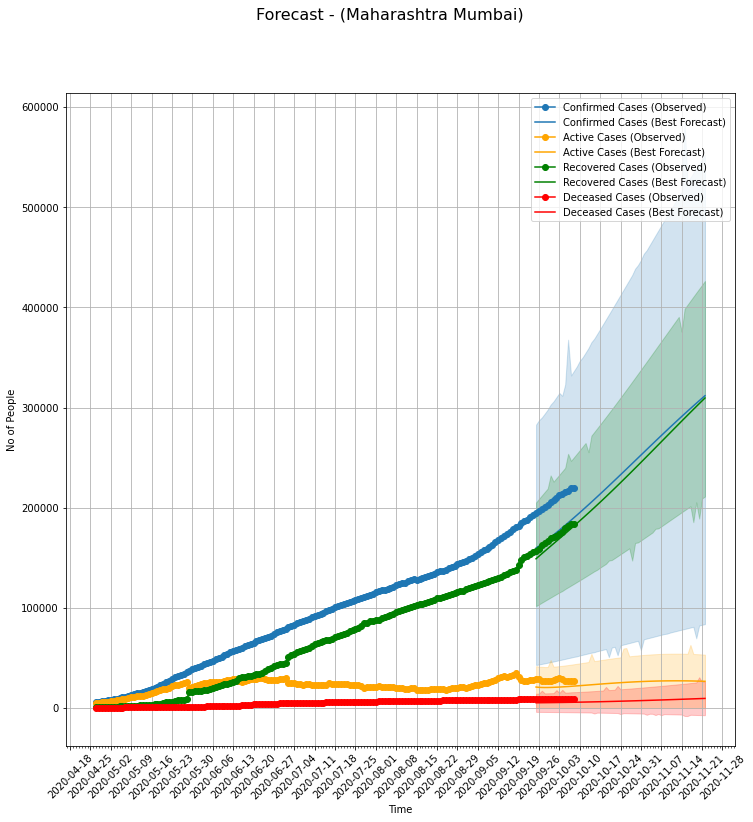

In [47]:
# Predictions plotted are for the most recent train_period days + test_period + forecast_period (no validation_period)
predictions_dict['m2']['plots']['forecast_best'] = plot_forecast(predictions_dict, 
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True)

In [48]:
predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

10it [00:00, 96.65it/s]getting forecasts ..
200it [00:02, 84.39it/s]


In [49]:
predictions_dict['m2']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m2', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'])

5it [00:00, 44.59it/s]getting forecasts ..
200it [00:02, 77.69it/s]


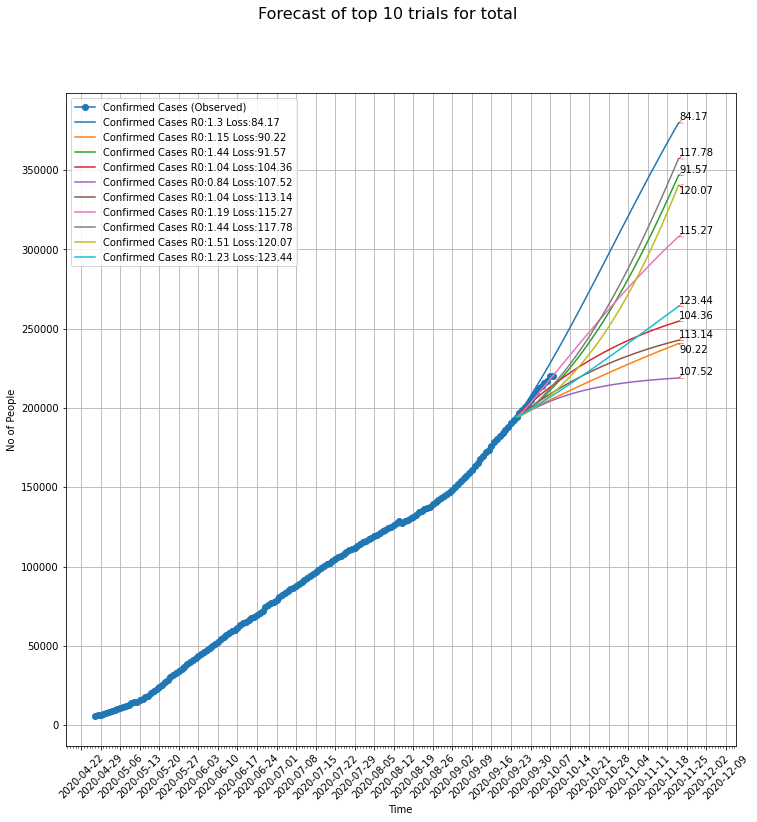

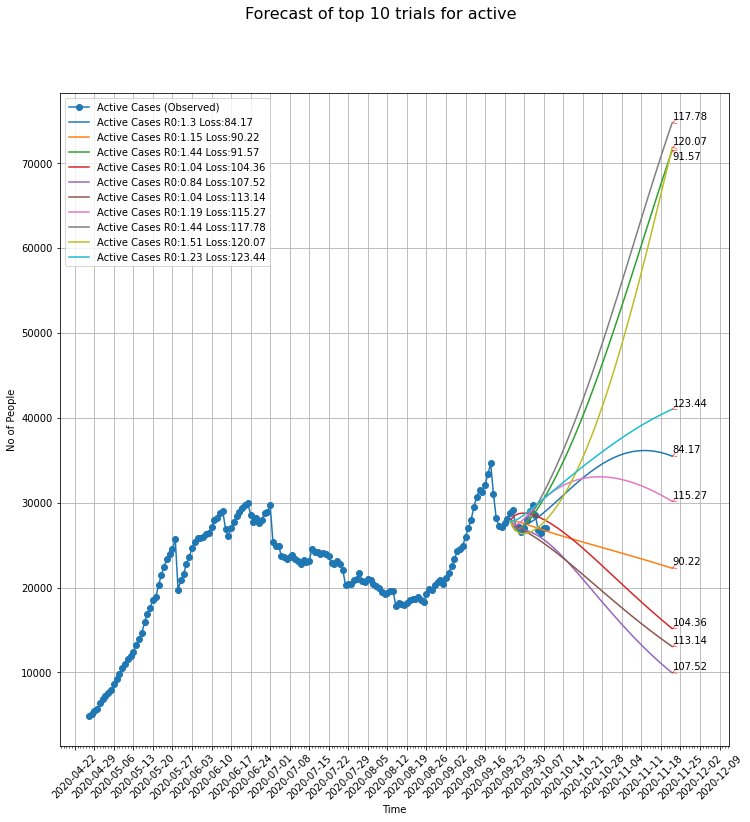

In [50]:
kforecasts = plot_top_k_trials(predictions_dict, train_fit='m2',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])

In [51]:
predictions_dict['m2']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m2']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [52]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

100%|██████████| 100/100 [00:11<00:00,  8.61trial/s, best loss: 88.95106419082614]


In [53]:
uncertainty.beta_loss

{'active': 100.06800318907659,
 'recovered': 47.705632605094735,
 'deceased': 123.16509910414,
 'total': 84.86552186499324}

In [54]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']
    
predictions_dict['m2']['forecasts']['ensemble_mean'] = uncertainty.ensemble_mean_forecast

In [55]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

101689  14613  10305    27905     5008  229497  10978   32913   
27 2020-10-22  1098254  14646  10342    28067     5111  232472  11105   33178   
28 2020-10-23  1094819  14673  10374    28222     5212  235464  11234   33434   
29 2020-10-24  1091384  14693  10402    28370     5311  238471  11366   33681   
30 2020-10-25  1087951  14707  10425    28511     5409  241494  11500   33920   
31 2020-10-26  1084522  14715  10444    28644     5504  244531  11636   34148   
32 2020-10-27  1081098  14716  10459    28769     5598  247581  11775   34367   
33 2020-10-28  1077681  14711  10469    28885     5689  250643  11917   34574   
34 2020-10-29  1074272  14700  10475    28992     5779  253718  12060   34771   
35 2020-10-30  1070873  14683  10477    29090     5866  256802  12206   34956   
36 2020-10-31  1067484  14659  10473    29178     5951  259897  12354   35129   
37 2020-11-01  1064108  14630  10466    29255     6034  263000  12504   35289   
38 2020-11-02  1060746  14594  10454    2932

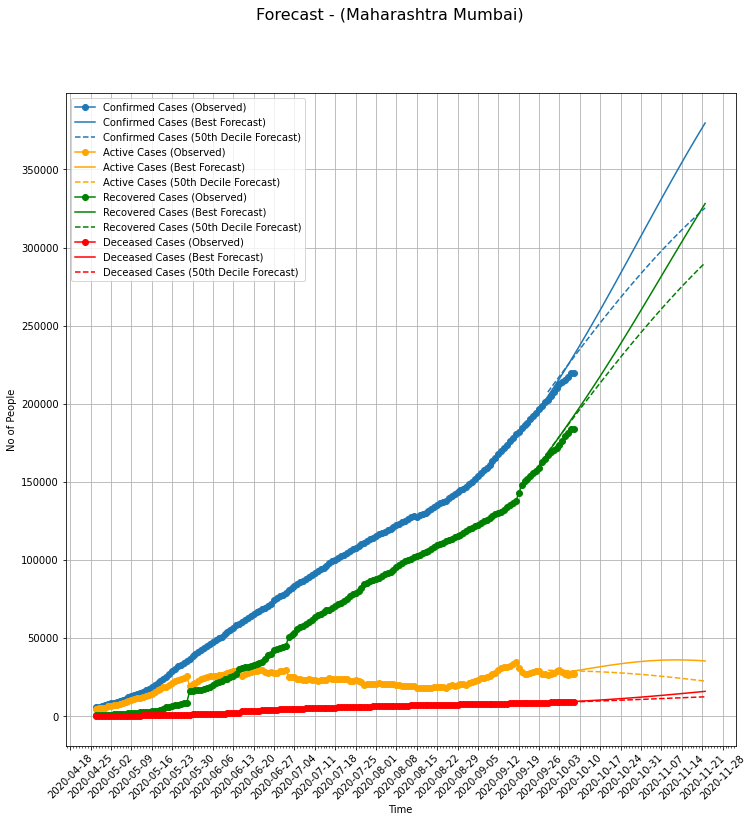

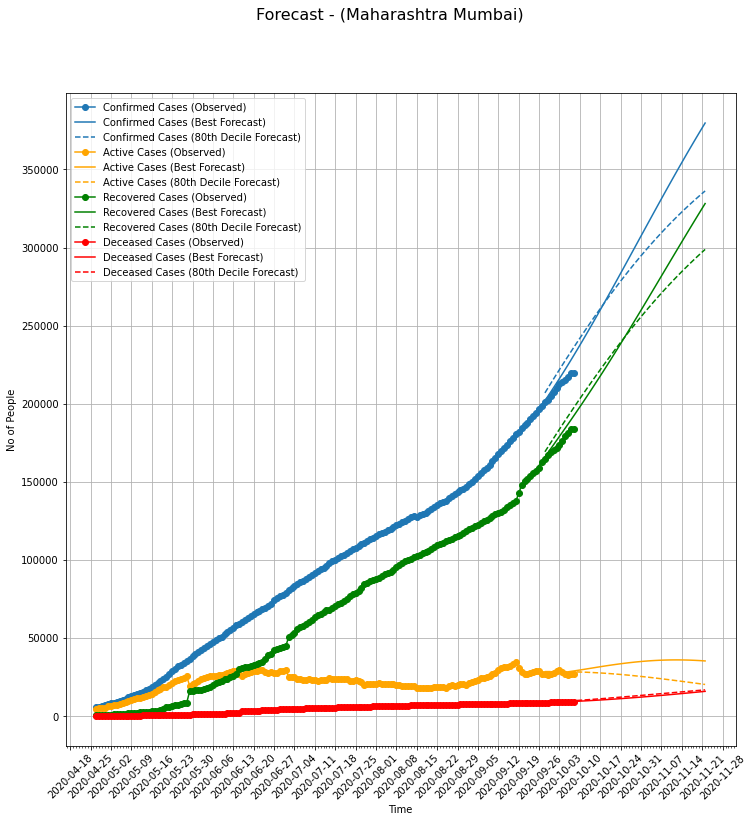

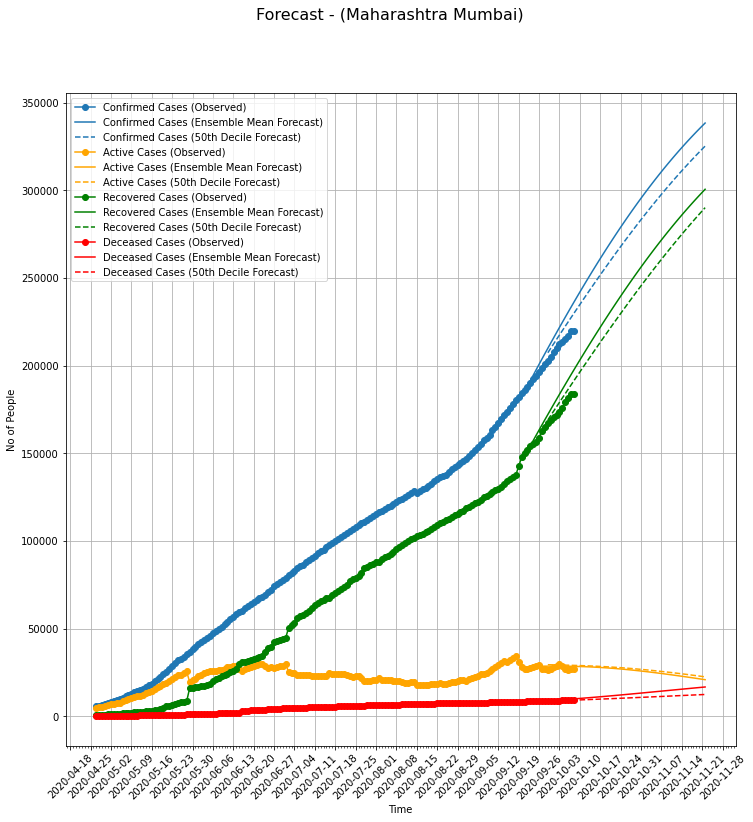

In [56]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)
predictions_dict['m2']['plots']['forecast_ensemble_mean_50'] = plot_forecast(predictions_dict, 
                                                                             (config['fitting']['data']['dataloading_params']['state'], 
                                                                              config['fitting']['data']['dataloading_params']['district']),
                                                                             fits_to_plot=['ensemble_mean', 50], error_bars=False)

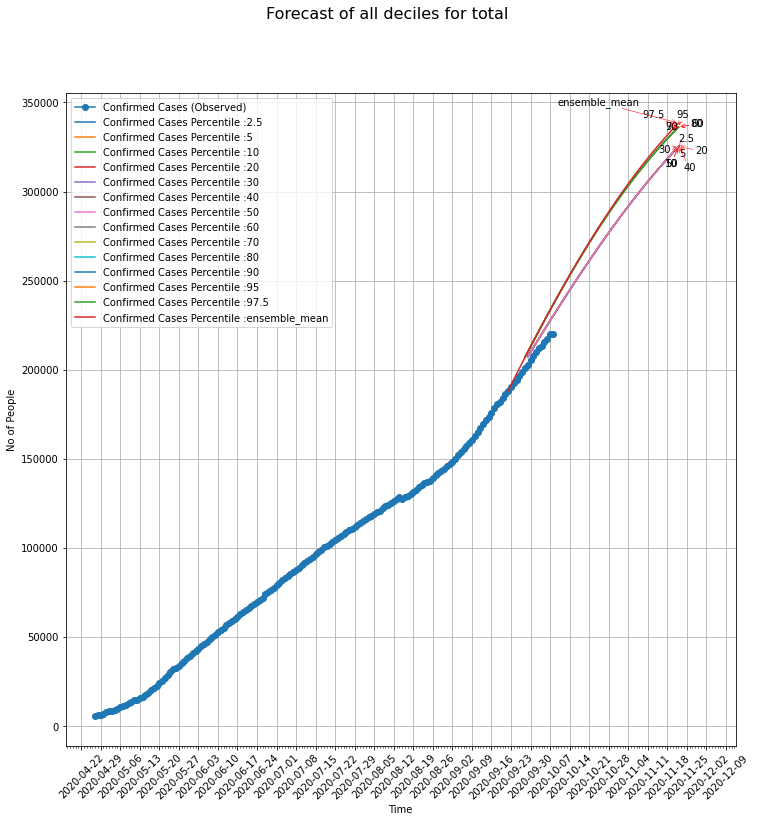

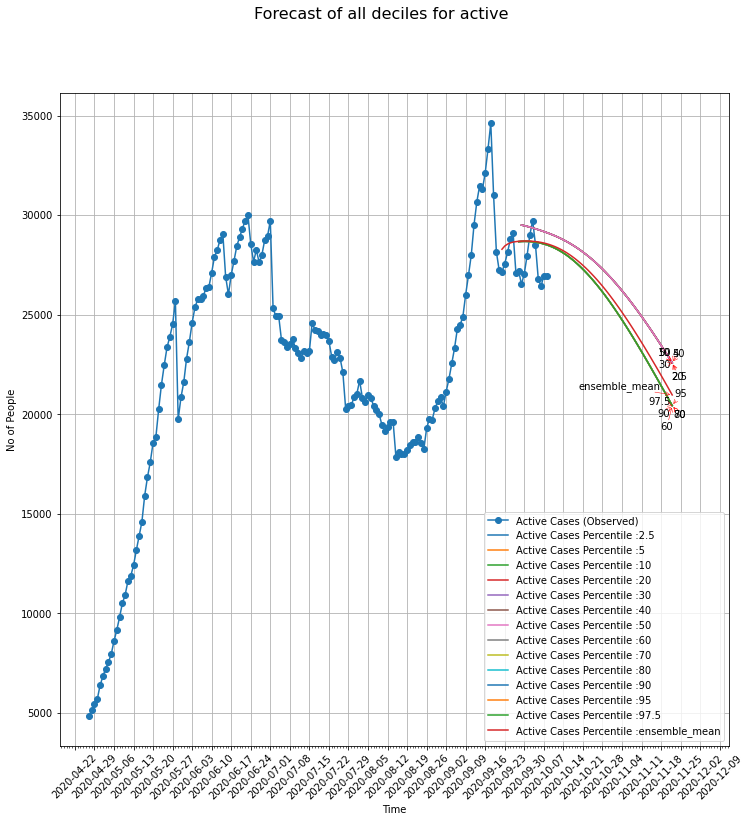

In [57]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## What If Scenarios - R0 Multipliers

getting forecasts ..
getting forecasts ..


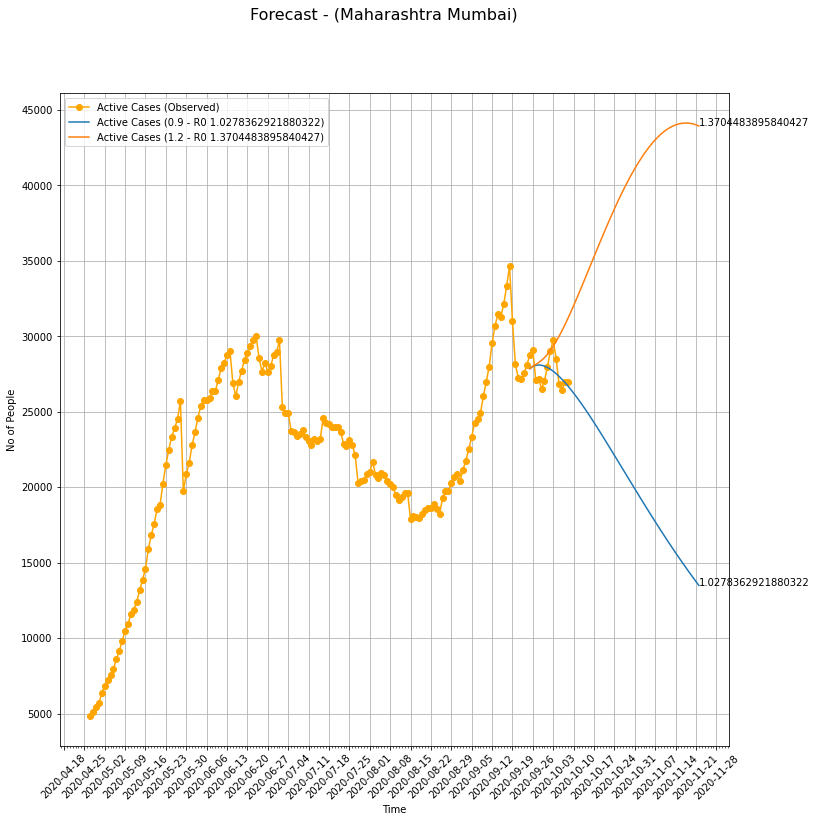

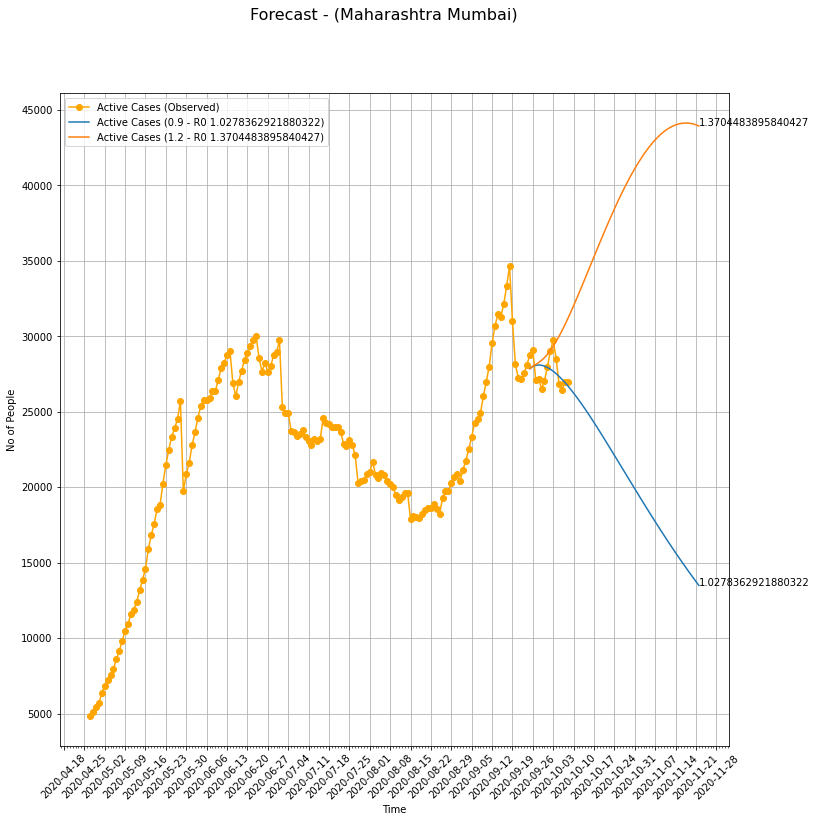

In [58]:
r0_mul_params= predictions_dict['m2']['deciles'][config['what_ifs']['percentile']]['params']
predictions_mul_dict = predict_r0_multipliers(predictions_dict, r0_mul_params, model=config['fitting']['model'],            days=config['forecast']['forecast_days'], multipliers=config['what_ifs']['multipliers'])
plot_r0_multipliers(predictions_dict, None, predictions_mul_dict, None, config['fitting']['data']['dataloading_params']['state'], config['fitting']['data']['dataloading_params']['district'])

## Create Report

In [59]:
save_dict_and_create_report(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

## Create Output

In [60]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

In [61]:
#log_wandb(predictions_dict)

## Create All Trials Output

In [62]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')

In [63]:
save_r0_mul(predictions_mul_dict, output_folder)

## Experiments

In [64]:
predictions_dict['m1'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'trials_processed'])

In [65]:
predictions_dict['m2'].keys()

dict_keys(['plots', 'best_params', 'default_params', 'variable_param_ranges', 'optimiser', 'df_prediction', 'df_district', 'df_train', 'df_val', 'df_loss', 'trials', 'data_last_date', 'df_district_unsmoothed', 'run_params', 'forecasts', 'trials_processed', 'beta', 'beta_loss', 'deciles'])